### Load Depth Anything Model

In [1]:
import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt

from depth_anything_v2.dpt import DepthAnythingV2

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vitl' # or 'vits', 'vitb', 'vitg'

model = DepthAnythingV2(**model_configs[encoder])
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_{encoder}.pth', map_location='cpu'))
model = model.to(DEVICE).eval()

xFormers not available
xFormers not available


### Test Model on Visual Random Image

Raw Image Size:  (720, 1280, 3)
Depth Size:  (720, 1280)
GT Depth Size:  (720, 1280)
Min Raw Image Pixel Value:  0
Max Raw Image Pixel Value:  255
Min depth:  0.0
Max depth:  531.4314
Min GT depth:  1.3063397404724733
Max GT depth:  153.12


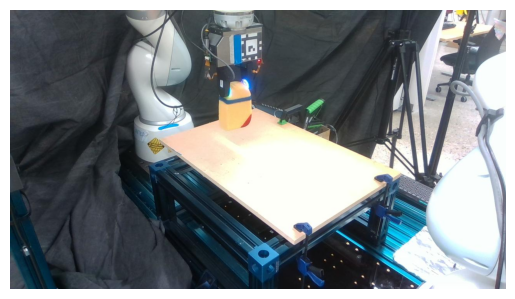

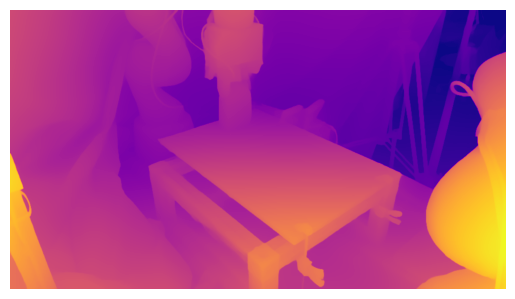

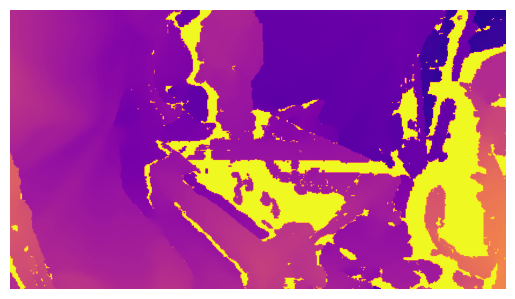

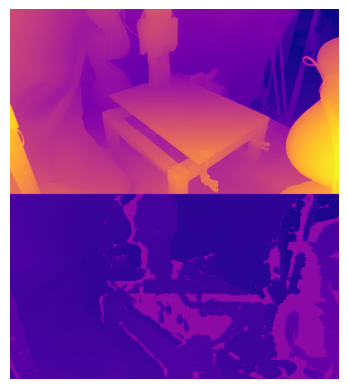

In [2]:
raw_img_path = '/home/samanta/tactile_4D_gaussian_splatting/data_dynamic/sponge_painted_deformable_capture/dynamic/videos_images/C0733/DSC_0002.JPG'
raw_img = cv2.imread(raw_img_path)
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2BGR)
depth = model.infer_image(raw_img) # HxW raw depth map in numpy
# depth = (depth - np.min(depth)) / (np.max(depth) - np.min(depth))

raw_depth_path = '/home/samanta/tactile_4D_gaussian_splatting/data_dynamic/sponge_painted_deformable_capture/dynamic/videos_depth/C0733/DSC_0002.npy'
gt_depth = np.load(raw_depth_path)
H, W = depth.shape[:2]
gt_depth = gt_depth.reshape(H, W)/1000 # In meters
gt_depth_disparity = 1/np.maximum(gt_depth, 1e-12)
gt_depth_disparity = np.clip(gt_depth_disparity, 0.0, 3.0) * 928 * 0.055
#TODO: Multiply by focal length and baseline distance to get disparity
# gt_depth_disparity = (gt_depth_disparity - np.min(gt_depth_disparity)) / (np.max(gt_depth_disparity) - np.min(gt_depth_disparity))

print('Raw Image Size: ', raw_img.shape)
print('Depth Size: ', depth.shape)
print('GT Depth Size: ', gt_depth_disparity.shape)
print('Min Raw Image Pixel Value: ', np.min(raw_img))
print('Max Raw Image Pixel Value: ', np.max(raw_img))
print('Min depth: ', np.min(depth))
print('Max depth: ', np.max(depth))
print('Min GT depth: ', np.min(gt_depth_disparity))
print('Max GT depth: ', np.max(gt_depth_disparity))

plt.figure()
plt.axis('off')
plt.imshow(raw_img)

plt.figure()
plt.axis('off')
plt.imshow(depth, cmap='plasma')

plt.figure()
plt.axis('off')
plt.imshow(gt_depth_disparity, cmap='plasma')

depths_cat = np.concatenate([depth, gt_depth_disparity], axis=0)
plt.figure()
plt.axis('off')
plt.imshow(depths_cat, cmap='plasma')

Depth Min:  0.0
Depth Max:  531.4314


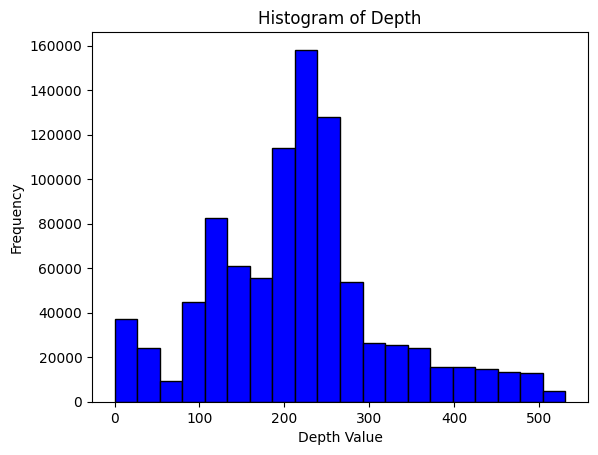

GT Depth Min:  1.3063397404724733
GT Depth Max:  153.12


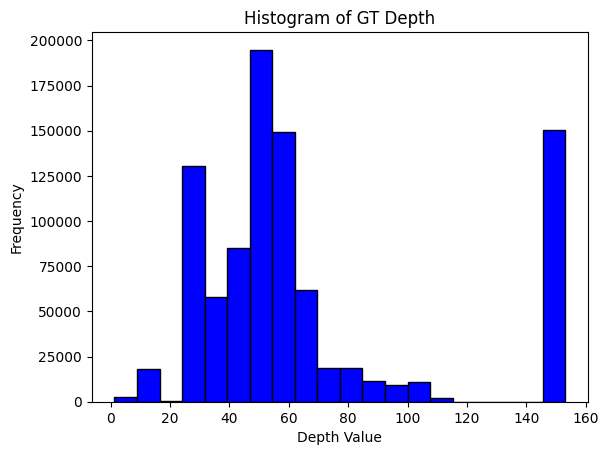

In [3]:
plt.figure()
print('Depth Min: ', np.min(depth))
print('Depth Max: ', np.max(depth))
plt.hist(depth.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

plt.figure()
print('GT Depth Min: ', np.min(gt_depth_disparity))
print('GT Depth Max: ', np.max(gt_depth_disparity))
plt.hist(gt_depth_disparity.flatten()[gt_depth_disparity.flatten() < 100000], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of GT Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

### Test on GelSlim Image

Gelslim Image Size:  (320, 427, 3)
Min Gelslim Image Pixel Value:  0.0
Max Gelslim Image Pixel Value:  255.0
Min depth:  102.62904
Max depth:  365.88916


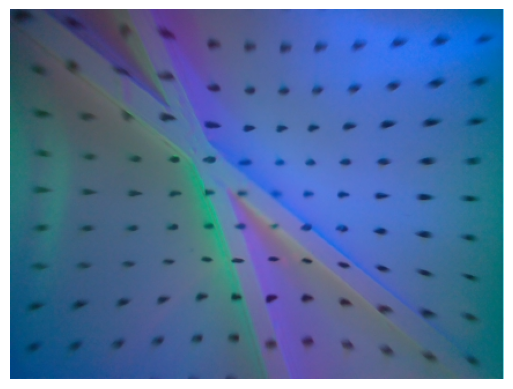

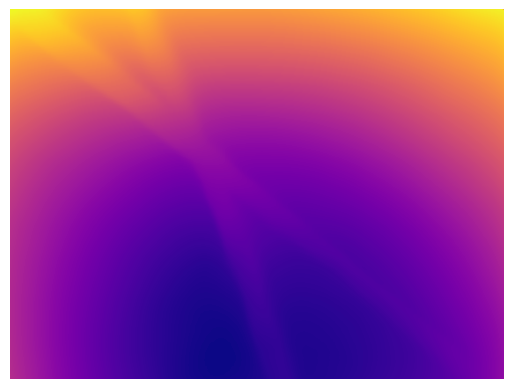

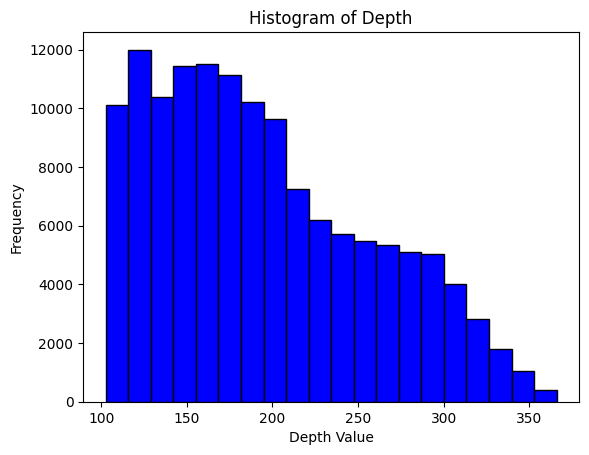

In [6]:
gelsim_path = '/home/samanta/T2D2T/data/train_only/gelslims/pattern_01_2_lines_angle_1_data_399.pt'
gelsim_image = torch.load(gelsim_path)['gelslim'][0].permute(1, 2, 0).numpy()
# gelsim_image *= 255
gelsim_image = cv2.cvtColor(gelsim_image, cv2.COLOR_RGB2BGR)
gelsim_depth = model.infer_image(gelsim_image) # HxW raw depth map in numpy
# gelsim_disparity = np.clip(gelsim_disparity, 1.0, 250.0)
# gelsim_depth = 1 / np.maximum(gelsim_depth, 1e-12)
# gelsim_depth = np.clip(gelsim_depth, 0.0, 0.06)

print('Gelslim Image Size: ', gelsim_image.shape)
print('Min Gelslim Image Pixel Value: ', np.min(gelsim_image))
print('Max Gelslim Image Pixel Value: ', np.max(gelsim_image))
print('Min depth: ', np.min(gelsim_depth))
print('Max depth: ', np.max(gelsim_depth))

plt.figure()
plt.axis('off')
gelsim_image_vis = (gelsim_image - np.min(gelsim_image)) / (np.max(gelsim_image) - np.min(gelsim_image))
gelsim_image_vis = cv2.cvtColor(gelsim_image_vis, cv2.COLOR_BGR2RGB)
plt.imshow(gelsim_image_vis)

plt.figure()
plt.axis('off')
plt.imshow(gelsim_depth, cmap='plasma')

plt.figure()
plt.hist(gelsim_depth.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

### Test on Soft Bubble Image

Bubble Image Size:  (140, 175, 3)
GT Depth Size:  (140, 175)
Min Bubble Image Pixel Value:  0.0
Max Bubble Image Pixel Value:  255.0
Min depth:  95.88313
Max depth:  231.76619
GT Depth Min:  8.885116
GT Depth Max:  14.370794


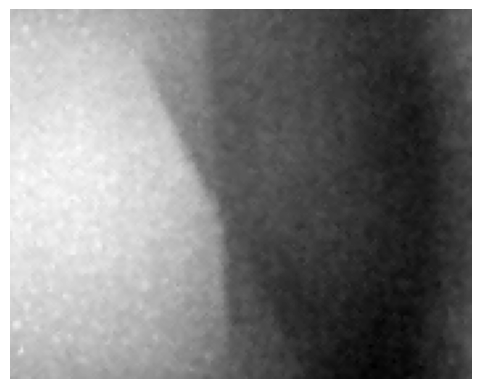

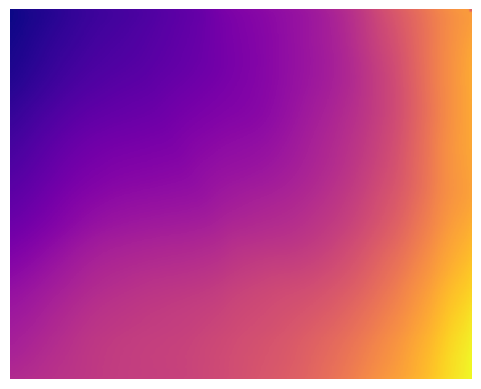

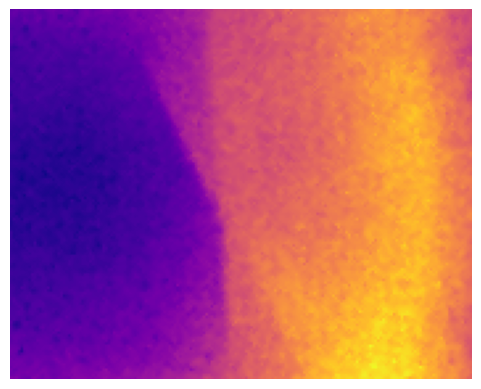

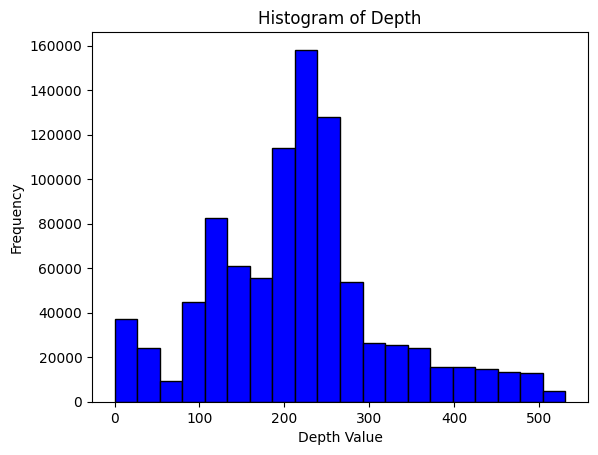

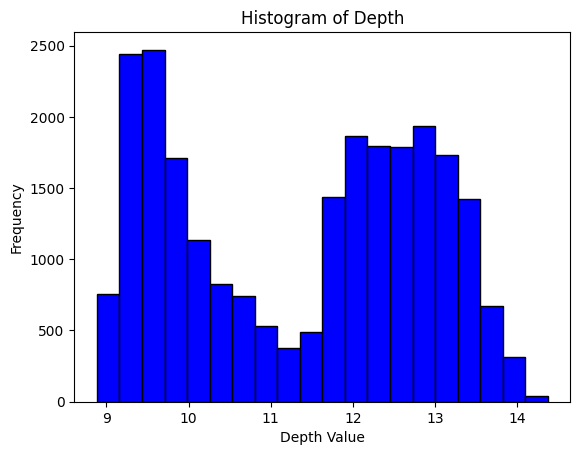

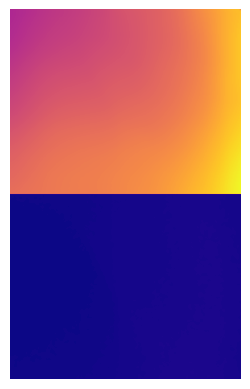

In [8]:
bubble_path = '/home/samanta/T2D2T/data/train_only/bubbles/pattern_01_2_lines_angle_1_data_8.pt'
bubble_imprint = torch.load(bubble_path)['bubble_imprint'][0].permute(1, 2, 0).repeat(1, 1, 3).numpy()
bubble_ref = torch.load(bubble_path)['bubble_depth_ref'][0].permute(1, 2, 0).repeat(1, 1, 3).numpy()
bubble_image = bubble_ref - bubble_imprint
bubble_image = (bubble_image - np.min(bubble_image)) / (np.max(bubble_image) - np.min(bubble_image))
bubble_image *= 255
# bubble_image = cv2.cvtColor(bubble_image, cv2.COLOR_RGB2BGR)
bubble_depth = model.infer_image(bubble_image) # HxW raw depth map in numpy
# bubble_depth = 1/np.maximum(bubble_depth, 1e-12) # 200*
# bubble_depth = (bubble_depth - np.min(bubble_depth)) / (np.max(bubble_depth) - np.min(bubble_depth))

gt_depth = bubble_ref[:,:,0] - bubble_imprint[:,:,0]
gt_depth = 1/gt_depth
# gt_depth = (gt_depth - np.min(gt_depth)) / (np.max(gt_depth) - np.min(gt_depth))

print('Bubble Image Size: ', bubble_image.shape)
print('GT Depth Size: ', gt_depth.shape)
print('Min Bubble Image Pixel Value: ', np.min(bubble_image))
print('Max Bubble Image Pixel Value: ', np.max(bubble_image))
print('Min depth: ', np.min(bubble_depth))
print('Max depth: ', np.max(bubble_depth))
print('GT Depth Min: ', np.min(gt_depth))
print('GT Depth Max: ', np.max(gt_depth))

plt.figure()
plt.axis('off')
plt.imshow(bubble_image[:,:,0]/255, cmap= 'gray') 

plt.figure()
plt.axis('off')
plt.imshow(bubble_depth, cmap='plasma')

plt.figure()
plt.axis('off')
plt.imshow(gt_depth, cmap='plasma')

plt.figure()
plt.hist(depth.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

plt.figure()
plt.hist(gt_depth.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

depths_cat = np.concatenate([bubble_depth, gt_depth], axis=0)
plt.figure()
plt.axis('off')
plt.imshow(depths_cat, cmap='plasma')